In [44]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf


**Data Reading and Understanding**

In [45]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = "/kaggle/input/teethdata/Teeth_Dataset"

In [46]:
# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/Training",
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
)

Found 3087 files belonging to 7 classes.


In [47]:
# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/Validation",
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
)



Found 1028 files belonging to 7 classes.


In [48]:
# Load test dataset (optional)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/Testing",
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
)

Found 1028 files belonging to 7 classes.


In [49]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


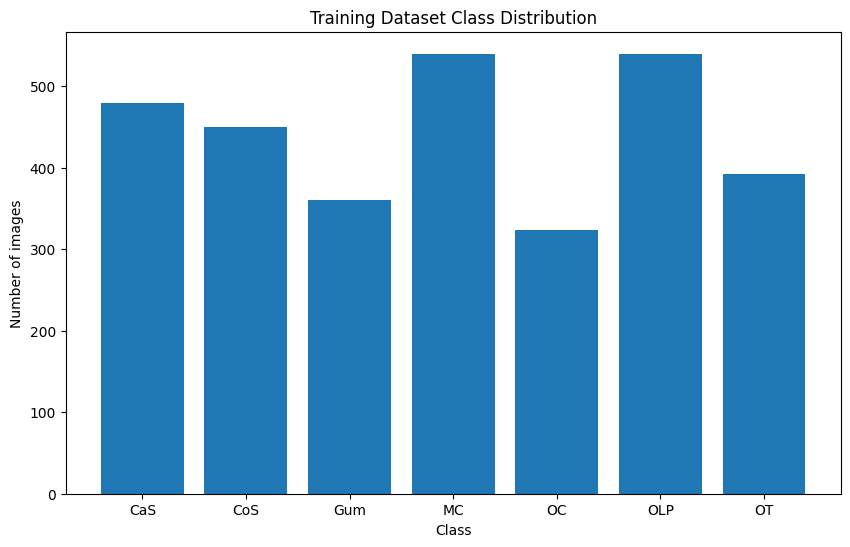

In [50]:
#Data distribution 

import matplotlib.pyplot as plt

# Count samples per class
class_counts = {class_name: 0 for class_name in class_names}
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Training Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()


In [51]:
import numpy as np
from collections import Counter

# Collect all labels from the dataset
all_labels = []

for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())

# Count each class
label_counts = Counter(all_labels)

# Map integer labels back to class names
for label_idx, count in sorted(label_counts.items()):
    class_name = class_names[label_idx]
    print(f"{class_name}: {count} images")


CaS: 480 images
CoS: 450 images
Gum: 360 images
MC: 540 images
OC: 324 images
OLP: 540 images
OT: 393 images


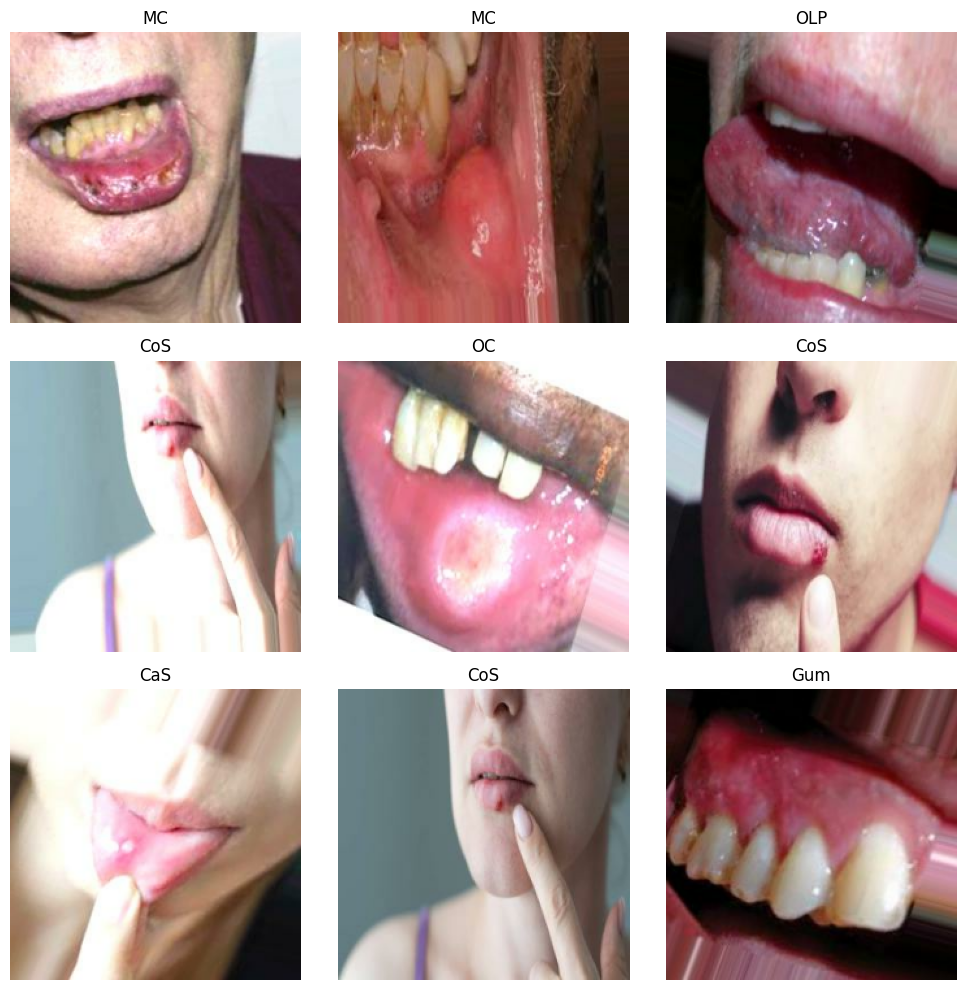

In [52]:
import matplotlib.pyplot as plt

# Display 9 sample images from the training set
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  # Take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()


**Preprocessing & Visualization**

Resize & Normalize

In [53]:
from tensorflow.keras import layers

# Resize and normalize layer
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255)
])


In [54]:
val_preprocessing = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
])

In [55]:
for images, labels in train_ds.take(1):
    original_img = images[0].numpy()
    resized_normalized_img = resize_and_rescale(images[0]).numpy()

    print("Original pixel range:", original_img.min(), "-", original_img.max())
    print("After normalization:", resized_normalized_img.min(), "-", resized_normalized_img.max())
    break

print("Original shape:", images[0].shape)
print("After resize:", resize_and_rescale(images[0]).shape)


Original pixel range: 0.21429062 - 255.0
After normalization: 0.0008403554 - 1.0
Original shape: (224, 224, 3)
After resize: (224, 224, 3)


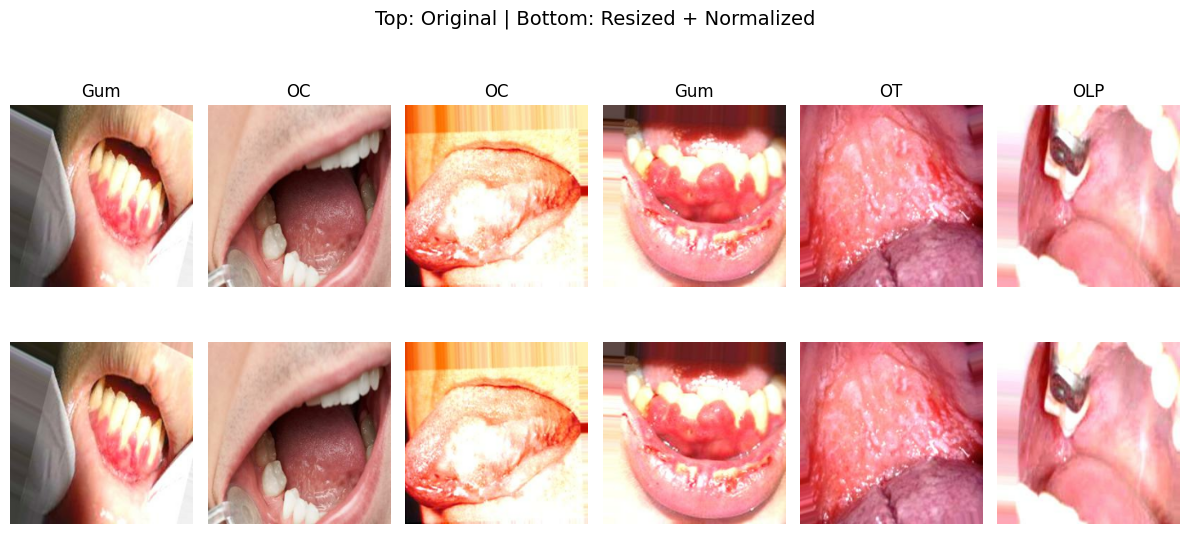

In [56]:
# Take 1 batch from training
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        # Original
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

        # After resize & normalize
        ax = plt.subplot(2, 6, i + 7)
        img_rescaled = resize_and_rescale(images[i])
        plt.imshow(img_rescaled.numpy())
        plt.axis("off")

    plt.suptitle("Top: Original | Bottom: Resized + Normalized", fontsize=14)
    plt.tight_layout()
    plt.show()
    break


Data Augmentation

In [67]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [68]:
#Combine Resize + Normalize + Augmentation
train_preprocessing = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
    data_augmentation
])


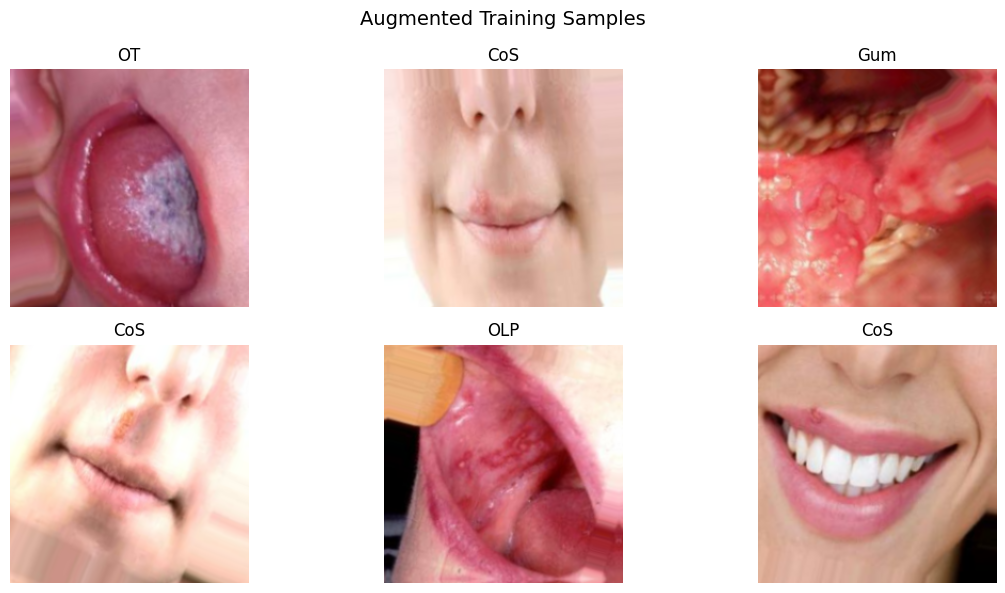

In [69]:
import matplotlib.pyplot as plt

# Take 1 batch from train_ds
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        augmented_image = train_preprocessing(images[i])
        plt.imshow(augmented_image.numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.suptitle("Augmented Training Samples", fontsize=14)
    plt.tight_layout()
    plt.show()
    break


In [70]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


**Modeling**

Model Architicture

In [84]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [71]:
model = models.Sequential([
    layers.InputLayer(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])


In [72]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,237,447 (50.50 MB)

 Trainable params: 13,236,487 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

Training

In [73]:
epochs = 35
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)


Epoch 1/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.2174 - loss: 10.9093 - val_accuracy: 0.1819 - val_loss: 1.9013
Epoch 2/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.2118 - loss: 1.8936 - val_accuracy: 0.2529 - val_loss: 1.8635
Epoch 3/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.2351 - loss: 1.8574 - val_accuracy: 0.2218 - val_loss: 1.8998
Epoch 4/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - accuracy: 0.2755 - loss: 1.8033 - val_accuracy: 0.2772 - val_loss: 1.8049
Epoch 5/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - accuracy: 0.2535 - loss: 1.8278 - val_accuracy: 0.2529 - val_loss: 1.9199
Epoch 6/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.2814 - loss: 1.7733 - val_accuracy: 0.2043 - val_loss: 3.7505
Epoch 7/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.3105 - loss: 1.7245 - val_accuracy: 0.2364 - val_loss: 2.7605
Epoch 8/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - accuracy: 0.2975 - loss: 1.7528 - val_accuracy: 0.3385 - 

Evaluation

In [74]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 637ms/step - accuracy: 0.6878 - loss: 1.0735
Validation Loss: 1.2186
Validation Accuracy: 0.6002


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

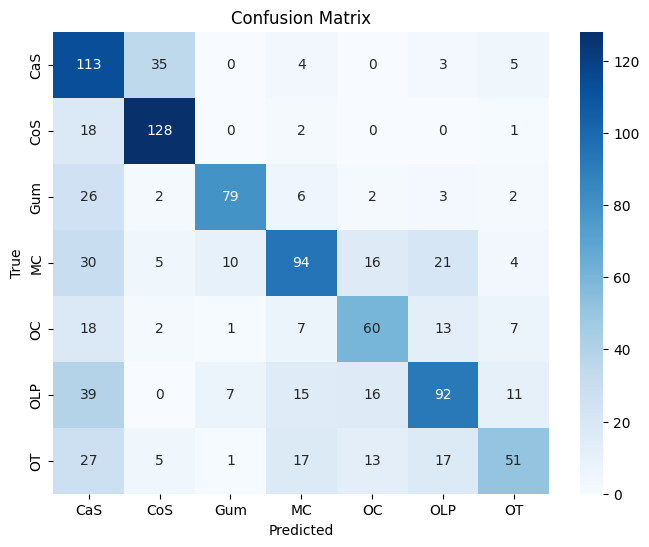

In [76]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get all predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**Transfer learning**

In [77]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0


In [78]:
base_model = EfficientNetB0(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')

base_model.trainable = False  # freeze pretrained weights initially


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [79]:
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # keep base_model in inference mode during training
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # prevent overfitting
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)


In [80]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [81]:
initial_epochs = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=initial_epochs)


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.3455 - loss: 1.6727 - val_accuracy: 0.6683 - val_loss: 1.0146
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.6664 - loss: 0.9690 - val_accuracy: 0.7344 - val_loss: 0.8302
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7217 - loss: 0.8408 - val_accuracy: 0.7811 - val_loss: 0.6988
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7724 - loss: 0.6985 - val_accuracy: 0.8006 - val_loss: 0.6292
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8021 - loss: 0.6232 - val_accuracy: 0.8249 - val_loss: 0.5643
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.8202 - loss: 0.5713 - val_accuracy: 0.8414 - val_loss: 0.5230
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8492 - loss: 0.5244 - val_accuracy: 0.8502 - val_loss: 0.4815
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8584 - loss: 0.4821 - val_accuracy: 0.8687 - v

In [82]:
# Unfreeze the base model
base_model.trainable = True

# Optional: Freeze first layers, fine-tune last layers only
fine_tune_at = 100  # example layer index
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1])


Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.4093 - loss: 1.7064 - val_accuracy: 0.7996 - val_loss: 0.6054
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.5681 - loss: 1.1876 - val_accuracy: 0.7442 - val_loss: 0.7085
Epoch 12/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.6716 - loss: 0.9176 - val_accuracy: 0.7733 - val_loss: 0.6763
Epoch 13/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.7368 - loss: 0.7888 - val_accuracy: 0.8006 - val_loss: 0.6155
Epoch 14/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7812 - loss: 0.6861 - val_accuracy: 0.8249 - val_loss: 0.5497
Epoch 15/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.7981 - loss: 0.6157 - val_accuracy: 0.8521 - val_loss: 0.4896
Epoch 16/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.8640 - loss: 0.4993 - val_accuracy: 0.8735 - val_loss: 0.4386
Epoch 17/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.8695 - loss: 0.4670 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━

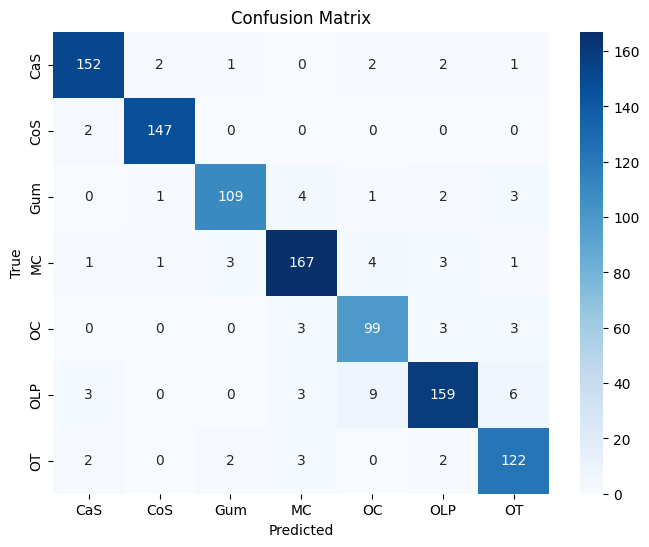

In [83]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get all predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()